# Прекод

# Сборный проект-4

Вам поручено разработать демонстрационную версию поиска изображений по запросу.

Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

## Описание данных

Данные доступны по [ссылке](https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip).

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.
3. Доля людей, подтвердивших, что описание соответствует изображению.
4. Количество человек, подтвердивших, что описание соответствует изображению.
5. Количество человек, подтвердивших, что описание не соответствует изображению.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов. Номера колонок и соответствующий тип данных:

1. Имя файла изображения.
2. Идентификатор описания.

3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где 1 — изображение и запрос совершенно не соответствуют друг другу, 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует, 3 — запрос и текст соответствуют с точностью до некоторых деталей, 4 — запрос и текст соответствуют полностью.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `test_images` содержатся изображения для тестирования модели.

## Исследовательский анализ данных

Наш датасет содержит экспертные и краудсорсинговые оценки соответствия текста и изображения.

В файле с экспертными мнениями для каждой пары изображение-текст имеются оценки от трёх специалистов. Для решения задачи вы должны эти оценки агрегировать — превратить в одну. Существует несколько способов агрегации оценок, самый простой — голосование большинства: за какую оценку проголосовала большая часть экспертов (в нашем случае 2 или 3), та оценка и ставится как итоговая. Поскольку число экспертов меньше числа классов, может случиться, что каждый эксперт поставит разные оценки, например: 1, 4, 2. В таком случае данную пару изображение-текст можно исключить из датасета.

Вы можете воспользоваться другим методом агрегации оценок или придумать свой.

В файле с краудсорсинговыми оценками информация расположена в таком порядке:

1. Доля исполнителей, подтвердивших, что текст **соответствует** картинке.
2. Количество исполнителей, подтвердивших, что текст **соответствует** картинке.
3. Количество исполнителей, подтвердивших, что текст **не соответствует** картинке.

После анализа экспертных и краудсорсинговых оценок выберите либо одну из них, либо объедините их в одну по какому-то критерию: например, оценка эксперта принимается с коэффициентом 0.6, а крауда — с коэффициентом 0.4.

Ваша модель должна возвращать на выходе вероятность соответствия изображения тексту, поэтому целевая переменная должна иметь значения от 0 до 1.


In [1]:
!pip install --upgrade protobuf

In [2]:
import torchvision.models as models
import torch
import torch.nn as nn
from torchvision import transforms
from torchvision import models
import numpy as np
import pandas as pd
import random as rd
import torch
import torch.nn as nn
from math import ceil
from PIL import Image
import os
import spacy
import re
import matplotlib.pyplot as plt
import os
from pathlib import Path
import time
from random import randrange

import nltk
from nltk.corpus import stopwords as nltk_stopwords

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.model_selection import GroupShuffleSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from tensorflow import keras
from tensorflow.keras.layers import Dense 
from tensorflow.keras.models import Sequential

2025-11-27 21:52:38.493103: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1764280358.760157      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1764280358.834147      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

In [3]:
path = '/kaggle/input/picture'

In [4]:
def first_check(df, dataset_name=''):
    # Печатаем название датасета (если их несколько)
    if dataset_name:
        print(f'Анализ датасета: {dataset_name}')
    else:
        print('Анализ датасета')
    print("=" * 40 + "\n")

    print('Первые 5 строк:')
    display(df.head())
    print('\nПоледние 5 строк:')
    display(df.tail())
    print('\nРазмерность датасета:')
    print(df.shape)

    print('\nИнформаци о данных')
    print(df.info())

    print('\nОписательная статистика:')
    display(df.describe(include='all'))

    print('\nНаличие пропусков и дублей:')
    display(df.duplicated().sum())

In [5]:
train_dataset = pd.read_csv('/kaggle/input/dfffff/train_dataset.csv')
train_dataset.columns=['file_name', 'query_id', 'query_text']
CrowdAnnotations = pd.read_table('/kaggle/input/dfffff/CrowdAnnotations.tsv',
                                   names=['file_name', 
                                          'query_id', 
                                          'target_crowd', 
                                          'num_votes_up', 
                                          'num_votes_down'])
ExpertAnnotations = pd.read_table('/kaggle/input/dfffff/ExpertAnnotations.tsv',
                                   names=['file_name', 
                                          'query_id', 
                                          'eval_1', 
                                          'eval_2', 
                                          'eval_3'])
test_queries = pd.read_csv('/kaggle/input/dfffff/test_queries.csv', sep='|', index_col=0)

In [6]:
first_check(train_dataset)

Анализ датасета

Первые 5 строк:


file_name                     query_id  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2   
1  1262583859_653f1469a9.jpg  2549968784_39bfbe44f9.jpg#2   
2  2447284966_d6bbdb4b6e.jpg  2549968784_39bfbe44f9.jpg#2   
3  2549968784_39bfbe44f9.jpg  2549968784_39bfbe44f9.jpg#2   
4  2621415349_ef1a7e73be.jpg  2549968784_39bfbe44f9.jpg#2   

                                          query_text  
0  A young child is wearing blue goggles and sitt...  
1  A young child is wearing blue goggles and sitt...  
2  A young child is wearing blue goggles and sitt...  
3  A young child is wearing blue goggles and sitt...  
4  A young child is wearing blue goggles and sitt...


Поледние 5 строк:


file_name                     query_id  \
5817  757046028_ff5999f91b.jpg  2061144717_5b3a1864f0.jpg#2   
5818  799486353_f665d7b0f0.jpg  2196107384_361d73a170.jpg#2   
5819  909808296_23c427022d.jpg  2112921744_92bf706805.jpg#2   
5820  929679367_ff8c7df2ee.jpg  3651971126_309e6a5e22.jpg#2   
5821  968081289_cdba83ce2e.jpg  2292406847_f366350600.jpg#2   

                                        query_text  
5817    A man in an ampitheater talking to a boy .  
5818     a old man walks down the uncrowded road .  
5819  A dog stands on the side of a grassy cliff .  
5820                  A blurry photo of two dogs .  
5821                   A man rows his boat below .


Размерность датасета:
(5822, 3)

Информаци о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   5822 non-null   object
 1   query_id    5822 non-null   object
 2   query_text  5822 non-null   object
dtypes: object(3)
memory usage: 136.6+ KB
None

Описательная статистика:


file_name                     query_id  \
count                        5822                         5822   
unique                       1000                          977   
top     3364151356_eecd07a23e.jpg  2600867924_cd502fc911.jpg#2   
freq                           10                           34   

                                               query_text  
count                                                5822  
unique                                                977  
top     Two dogs , one brown and white and one black a...  
freq                                                   34


Наличие пропусков и дублей:


0

Пропусков и явных дубликатов нет.

Переведем текст запросов в леммы

In [7]:
df = pd.DataFrame(train_dataset['file_name']).drop_duplicates('file_name').reset_index(drop=True)

In [8]:
df_query = train_dataset[['query_id', 'query_text']].drop_duplicates().reset_index(drop=True)

In [9]:
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])


In [10]:
def lemmatize_text(df):
    df['lem_query_text'] = df['query_text'].apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))    
    return df

In [11]:
df_query = lemmatize_text(df_query)

In [12]:
first_check(CrowdAnnotations)

Анализ датасета

Первые 5 строк:


file_name                     query_id  target_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   num_votes_up  num_votes_down  
0             3               0  
1             0               3  
2             0               3  
3             0               3  
4             0               3


Поледние 5 строк:


file_name                    query_id  target_crowd  \
47825  997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2      0.000000   
47826  997722733_0cb5439472.jpg  544576742_283b65fa0d.jpg#2      0.333333   
47827  997722733_0cb5439472.jpg  872622575_ba1d3632cc.jpg#2      1.000000   
47828  997722733_0cb5439472.jpg  888425986_e4b6c12324.jpg#2      0.000000   
47829  997722733_0cb5439472.jpg  997722733_0cb5439472.jpg#2      0.666667   

       num_votes_up  num_votes_down  
47825             0               3  
47826             1               2  
47827             3               0  
47828             0               3  
47829             2               1


Размерность датасета:
(47830, 5)

Информаци о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       47830 non-null  object 
 1   query_id        47830 non-null  object 
 2   target_crowd    47830 non-null  float64
 3   num_votes_up    47830 non-null  int64  
 4   num_votes_down  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB
None

Описательная статистика:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


file_name                    query_id  target_crowd  \
count                       47830                       47830  47830.000000   
unique                       1000                        1000           NaN   
top     1572532018_64c030c974.jpg  249394748_2e4acfbbb5.jpg#2           NaN   
freq                          120                         169           NaN   
mean                          NaN                         NaN      0.068786   
std                           NaN                         NaN      0.207532   
min                           NaN                         NaN      0.000000   
25%                           NaN                         NaN      0.000000   
50%                           NaN                         NaN      0.000000   
75%                           NaN                         NaN      0.000000   
max                           NaN                         NaN      1.000000   

        num_votes_up  num_votes_down  
count   47830.000000    47830.000000  
unique           NaN             NaN  
top              NaN             NaN  
freq             NaN             NaN  
mean        0.208488        2.820155  
std         0.628898        0.656676  
min         0.000000        0.000000  
25%         0.000000        3.000000  
50%         0.000000        3.000000  
75%         0.000000        3.000000  
max         5.000000        6.000000


Наличие пропусков и дублей:


0

Пропусков и явных дубликатов нет.

In [13]:
first_check(ExpertAnnotations)

Анализ датасета

Первые 5 строк:


file_name                     query_id  eval_1  eval_2  \
0  1056338697_4f7d7ce270.jpg  2549968784_39bfbe44f9.jpg#2       1       1   
1  1056338697_4f7d7ce270.jpg  2718495608_d8533e3ac5.jpg#2       1       1   
2  1056338697_4f7d7ce270.jpg  3181701312_70a379ab6e.jpg#2       1       1   
3  1056338697_4f7d7ce270.jpg  3207358897_bfa61fa3c6.jpg#2       1       2   
4  1056338697_4f7d7ce270.jpg  3286822339_5535af6b93.jpg#2       1       1   

   eval_3  
0       1  
1       2  
2       2  
3       2  
4       2


Поледние 5 строк:


file_name                     query_id  eval_1  eval_2  \
5817  997722733_0cb5439472.jpg  2981702521_2459f2c1c4.jpg#2       1       1   
5818  997722733_0cb5439472.jpg  2985679744_75a7102aab.jpg#2       1       1   
5819  997722733_0cb5439472.jpg  3150742439_b8a352e1e0.jpg#2       1       1   
5820  997722733_0cb5439472.jpg  3375070563_3c290a7991.jpg#2       1       1   
5821  997722733_0cb5439472.jpg   486917990_72bd4069af.jpg#2       3       3   

      eval_3  
5817       1  
5818       1  
5819       2  
5820       1  
5821       3


Размерность датасета:
(5822, 5)

Информаци о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  5822 non-null   object
 1   query_id   5822 non-null   object
 2   eval_1     5822 non-null   int64 
 3   eval_2     5822 non-null   int64 
 4   eval_3     5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.6+ KB
None

Описательная статистика:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


file_name                     query_id       eval_1  \
count                        5822                         5822  5822.000000   
unique                       1000                          977          NaN   
top     3107513635_fe8a21f148.jpg  2600867924_cd502fc911.jpg#2          NaN   
freq                           10                           34          NaN   
mean                          NaN                          NaN     1.436620   
std                           NaN                          NaN     0.787084   
min                           NaN                          NaN     1.000000   
25%                           NaN                          NaN     1.000000   
50%                           NaN                          NaN     1.000000   
75%                           NaN                          NaN     2.000000   
max                           NaN                          NaN     4.000000   

             eval_2       eval_3  
count   5822.000000  5822.000000  
unique          NaN          NaN  
top             NaN          NaN  
freq            NaN          NaN  
mean       1.624356     1.881999  
std        0.856222     0.904087  
min        1.000000     1.000000  
25%        1.000000     1.000000  
50%        1.000000     2.000000  
75%        2.000000     2.000000  
max        4.000000     4.000000


Наличие пропусков и дублей:


0

Удалим строки, где мнение у экспертов отлично друг от друга

In [14]:
ExpertAnnotations.loc[(ExpertAnnotations['eval_1'] != ExpertAnnotations['eval_2']) &
                        (ExpertAnnotations['eval_2'] != ExpertAnnotations['eval_3']) &
                        (ExpertAnnotations['eval_3'] != ExpertAnnotations['eval_1']), 'file_name'].count()

126

In [15]:
ExpertAnnotations = ExpertAnnotations.drop(
    ExpertAnnotations[(ExpertAnnotations['eval_1'] != ExpertAnnotations['eval_2']) &
                        (ExpertAnnotations['eval_2'] != ExpertAnnotations['eval_3']) &
                        (ExpertAnnotations['eval_3'] != ExpertAnnotations['eval_1'])].index
)

In [16]:
def most_votes(df):
    
    df['target_experts'] = 0
    
    df.loc[(df['eval_1'] == df['eval_2']) &
           (df['eval_2'] == df['eval_3']), 'target_experts'] = ((df['eval_1'] - 1) / 3).round(4)
    
    df.loc[df['target_experts'] == 0, 'target_experts'] = ((df['eval_2'] - 1) / 3).round(4)
    
    return df

In [17]:
ExpertAnnotations = most_votes(ExpertAnnotations)

/tmp/ipykernel_13/241280484.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.     0.     0.     ... 0.     0.     0.6667]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[(df['eval_1'] == df['eval_2']) &


In [18]:
first_check(test_queries)

Анализ датасета

Первые 5 строк:


query_id  \
0  1177994172_10d143cb8d.jpg#0   
1  1177994172_10d143cb8d.jpg#1   
2  1177994172_10d143cb8d.jpg#2   
3  1177994172_10d143cb8d.jpg#3   
4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                       image  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg


Поледние 5 строк:


query_id  \
495  989851184_9ef368e520.jpg#0   
496  989851184_9ef368e520.jpg#1   
497  989851184_9ef368e520.jpg#2   
498  989851184_9ef368e520.jpg#3   
499  989851184_9ef368e520.jpg#4   

                                            query_text  \
495          A black dog has a dumbbell in his mouth .   
496  A black dog has a dumbbell in his mouth lookin...   
497  A black dog holding a weight in its mouth stan...   
498  A black dog holds a small white dumbbell in it...   
499  The black dog has a toy in its mouth and a per...   

                        image  
495  989851184_9ef368e520.jpg  
496  989851184_9ef368e520.jpg  
497  989851184_9ef368e520.jpg  
498  989851184_9ef368e520.jpg  
499  989851184_9ef368e520.jpg


Размерность датасета:
(500, 3)

Информаци о данных
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 0 to 499
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   query_id    500 non-null    object
 1   query_text  500 non-null    object
 2   image       500 non-null    object
dtypes: object(3)
memory usage: 15.6+ KB
None

Описательная статистика:


query_id  \
count                           500   
unique                          500   
top     1177994172_10d143cb8d.jpg#0   
freq                              1   

                                               query_text  \
count                                                 500   
unique                                                500   
top     Two blonde boys , one in a camouflage shirt an...   
freq                                                    1   

                            image  
count                         500  
unique                        100  
top     1177994172_10d143cb8d.jpg  
freq                            5


Наличие пропусков и дублей:


0

Пропусков и явных дубликатов нет.

In [19]:
diff = []
for query_id in CrowdAnnotations['query_id'].unique():
    if query_id not in train_dataset['query_id'].unique():
        diff.append(query_id)

In [20]:
#Объединим таблицу с оценками
train_data = CrowdAnnotations.merge(ExpertAnnotations,
                                      how='outer', 
                                      on=['file_name', 'query_id']).drop(['eval_1', 
                                                                          'eval_2', 
                                                                          'eval_3',
                                                                          'num_votes_up',
                                                                          'num_votes_down'], axis=1)

In [21]:
train_data.isna().sum()


file_name             0
query_id              0
target_crowd       3438
target_experts    45572
dtype: int64

In [22]:
#Объединим таблицу с оценками и таблицу с запросами
train_data = train_data.merge(df_query, 
                              how='inner', 
                              on=['query_id'])

In [23]:
first_check(train_data)

Анализ датасета

Первые 5 строк:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


file_name                     query_id  target_crowd  \
0  1056338697_4f7d7ce270.jpg  1056338697_4f7d7ce270.jpg#2           1.0   
1  1056338697_4f7d7ce270.jpg   114051287_dd85625a04.jpg#2           0.0   
2  1056338697_4f7d7ce270.jpg  1427391496_ea512cbe7f.jpg#2           0.0   
3  1056338697_4f7d7ce270.jpg  2073964624_52da3a0fc4.jpg#2           0.0   
4  1056338697_4f7d7ce270.jpg  2083434441_a93bc6306b.jpg#2           0.0   

   target_experts                                         query_text  \
0             NaN  A woman is signaling is to traffic , as seen f...   
1             NaN          A boy in glasses is wearing a red shirt .   
2             NaN   A young boy holds onto a blue handle on a pier .   
3             NaN  A woman wearing black clothes , a purple scarf...   
4             NaN  An older woman with blond hair rides a bicycle...   

                                      lem_query_text  
0  a woman be signal be to traffic , as see from ...  
1               a boy in glass be wear a red shirt .  
2    a young boy hold onto a blue handle on a pier .  
3  a woman wear black clothe , a purple scarf , a...  
4  an old woman with blond hair ride a bicycle do...


Поледние 5 строк:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


file_name                    query_id  target_crowd  \
50154  997722733_0cb5439472.jpg  543007912_23fc735b99.jpg#2      0.000000   
50155  997722733_0cb5439472.jpg  544576742_283b65fa0d.jpg#2      0.333333   
50156  997722733_0cb5439472.jpg  872622575_ba1d3632cc.jpg#2      1.000000   
50157  997722733_0cb5439472.jpg  888425986_e4b6c12324.jpg#2      0.000000   
50158  997722733_0cb5439472.jpg  997722733_0cb5439472.jpg#2      0.666667   

       target_experts                                         query_text  \
50154             NaN                     Two girls with orange shirts .   
50155             NaN                   A woman in jeans rock climbing .   
50156             NaN         A man is climbing the side of a mountain .   
50157             NaN                      A person flipping upside down   
50158             NaN  A person in a red shirt climbing up a rock fac...   

                                          lem_query_text  
50154                       two girl with orange shirt .  
50155                    a woman in jean rock climbing .  
50156            a man be climb the side of a mountain .  
50157                          a person flip upside down  
50158  a person in a red shirt climb up a rock face c...


Размерность датасета:
(50159, 6)

Информаци о данных
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50159 entries, 0 to 50158
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       50159 non-null  object 
 1   query_id        50159 non-null  object 
 2   target_crowd    46721 non-null  float64
 3   target_experts  5696 non-null   float64
 4   query_text      50159 non-null  object 
 5   lem_query_text  50159 non-null  object 
dtypes: float64(2), object(4)
memory usage: 2.3+ MB
None

Описательная статистика:


/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


file_name                    query_id  target_crowd  \
count                       50159                       50159  46721.000000   
unique                       1000                         977           NaN   
top     1572532018_64c030c974.jpg  249394748_2e4acfbbb5.jpg#2           NaN   
freq                          118                         176           NaN   
mean                          NaN                         NaN      0.069567   
std                           NaN                         NaN      0.208556   
min                           NaN                         NaN      0.000000   
25%                           NaN                         NaN      0.000000   
50%                           NaN                         NaN      0.000000   
75%                           NaN                         NaN      0.000000   
max                           NaN                         NaN      1.000000   

        target_experts              query_text     lem_query_text  
count      5696.000000                   50159              50159  
unique             NaN                     977                977  
top                NaN  Two white dogs running  two white dog run  
freq               NaN                     176                176  
mean          0.203821                     NaN                NaN  
std           0.286367                     NaN                NaN  
min           0.000000                     NaN                NaN  
25%           0.000000                     NaN                NaN  
50%           0.000000                     NaN                NaN  
75%           0.333300                     NaN                NaN  
max           1.000000                     NaN                NaN


Наличие пропусков и дублей:


0

**Определим итоговые оценки**

In [24]:
train_data.loc[train_data['target_crowd'].isna(),'total_target'] = train_data['target_experts']
train_data.loc[train_data['target_experts'].isna(),'total_target'] = train_data['target_crowd']

In [25]:
train_data.loc[train_data['total_target'].isna(),
               'total_target'] = train_data[['target_experts', 'target_crowd']].mean(axis=1)

In [26]:
train_data['total_target'].isna().sum()

0

Удалим лишние столбцы с данными

In [27]:
train_data = train_data.drop(['target_experts', 'target_crowd'], axis=1)

Посмотрим на распределение оценок

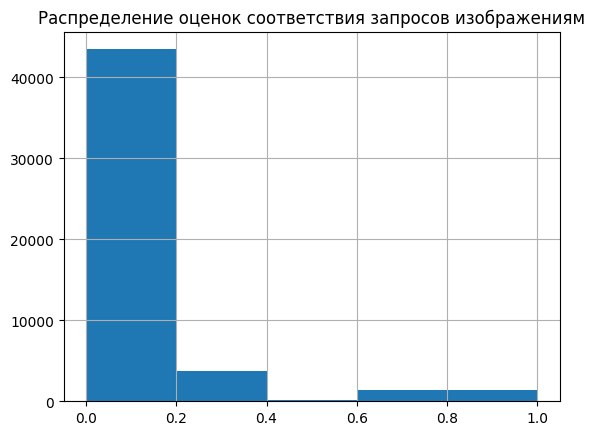

In [28]:
train_data['total_target'].hist(bins=5)
plt.title('Распределение оценок соответствия запросов изображениям');

Количество оценок ближе к нулю больше, чем оценок близких к единице

In [29]:
print((train_data.loc[train_data['total_target'] > 0.5, 
                      'total_target'].count() / len(train_data['total_target'])).round(3))

0.057


Доля оценок больше 0.5 составляет только 6 % от всей выборки. Фиксируем дисбаланс классов в оценках.

## Проверка данных

В некоторых странах, где работает ваша компания, действуют ограничения по обработке изображений: поисковым сервисам и сервисам, предоставляющим возможность поиска, запрещено без разрешения родителей или законных представителей предоставлять любую информацию, в том числе, но не исключительно тексты, изображения, видео и аудио, содержащие описание, изображение или запись голоса детей. Ребёнком считается любой человек, не достигший 16 лет.

В вашем сервисе строго следуют законам стран, в которых работают. Поэтому при попытке посмотреть изображения, запрещённые законодательством, вместо картинок показывается дисклеймер:

> This image is unavailable in your country in compliance with local laws
>

Однако у вас в PoC нет возможности воспользоваться данным функционалом. Поэтому все изображения, которые нарушают данный закон, нужно удалить из обучающей выборки.

In [30]:
stop_words = ['boy', 'girl', 'child', 'teenage', 'teenager', 'kid', 'baby']

In [31]:
%%time
stop_words_indices = []
for i in range(len(train_data)):
    for word in stop_words:
        if (word in train_data.loc[i, 'lem_query_text'].lower()) and (
            i not in stop_words_indices):
            
            stop_words_indices.append(i)
            
print(len(stop_words_indices))

14151
CPU times: user 4.05 s, sys: 0 ns, total: 4.05 s
Wall time: 4.05 s


In [32]:
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=10101)

In [33]:
train_index, valid_indices = next(
    gss.split(X=train_data.drop(['total_target'], axis=1), 
              y=train_data['total_target'], groups=train_data['file_name'])
)

X_train, X_valid, y_train, y_valid = (
    train_data.drop('total_target', axis=1).loc[train_index],
    train_data.drop('total_target', axis=1).loc[valid_indices],
    train_data['total_target'].loc[train_index],
    train_data['total_target'].loc[valid_indices]
)

На данном этапе мы удалили из обучающей выборки все запросы, в которых присутствует упоминение детей и разделили данные на обучающую и валидационную выборку в пропорции 7:3.

## Векторизация изображений

Перейдём к векторизации изображений.

Самый примитивный способ — прочесть изображение и превратить полученную матрицу в вектор. Такой способ нам не подходит: длина векторов может быть сильно разной, так как размеры изображений разные. Поэтому стоит обратиться к свёрточным сетям: они позволяют "выделить" главные компоненты изображений. Как это сделать? Нужно выбрать какую-либо архитектуру, например ResNet-18, посмотреть на слои и исключить полносвязные слои, которые отвечают за конечное предсказание. При этом можно загрузить модель данной архитектуры, предварительно натренированную на датасете ImageNet.

In [34]:
resnet = models.resnet18(weights=None)

for param in resnet.parameters():
    param.requires_grad_(False)

modules = list(resnet.children())[:-1]
resnet = nn.Sequential(*modules)
resnet.eval()

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [35]:
norm = transforms.Normalize(
    mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

In [36]:
def img_to_vect(image_name, img_folder_name):
       
    img = Image.open(path + '/' + image_name).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    img_vector = resnet(image_tensor).flatten().numpy()
    
    return img_vector

In [37]:
def df_img_vectorizer(df, img_folder_name):
       
    df['img_vector'] = df['file_name'].apply(lambda x: img_to_vect(x, img_folder_name))
    
    return df

In [38]:
path2 = '/kaggle/input/dfffff/test_images/'

In [39]:
def img_to_vect2(image_name, img_folder_name):
       
    img = Image.open(path2 + image_name).convert('RGB')
    image_tensor = preprocess(img).unsqueeze(0)
    img_vector = resnet(image_tensor).flatten().numpy()
    
    return img_vector

def df_img_vectorizer2(df, img_folder_name):
       
    df['img_vector'] = df['file_name'].apply(lambda x: img_to_vect2(x, img_folder_name))
    
    return df

In [40]:
%%time
df = df_img_vectorizer(df, 'train_images')

CPU times: user 2min 4s, sys: 1.54 s, total: 2min 6s
Wall time: 1min 7s


In [41]:
X_train = X_train.merge(df, on='file_name', how='left')

In [42]:
X_valid = X_valid.merge(df, on='file_name', how='left')

На данном этапе мы сделали две функции:
1) Первая принимает имя файла изображения и путь до него, а на выходе выдает векторное представление данного изображения.
2) Вторая принимает датафрейм с именами файлов изображений в столбце file_name и имя папки с изображениями. После отдает нам тот же датафрейм, но с добаленным столбцом img_vector, в котором хранится информация о векторе изображения из первой функции

Также объединили датафрейм с обучающей и валидационной таблицей оценок

## Векторизация текстов

Следующий этап — векторизация текстов. Вы можете поэкспериментировать с несколькими способами векторизации текстов:

- tf-idf
- word2vec
- \*трансформеры (например Bert)

\* — если вы изучали трансформеры в спринте Машинное обучение для текстов.


In [43]:
tv = TfidfVectorizer()
tv.fit(X_train['lem_query_text'].drop_duplicates());

In [44]:
def text_to_vect(df):        
    text_features_array = tv.transform(df['lem_query_text']).toarray()    
    return text_features_array

В рамках данного шага получили массив векторных представлений текстов

## Объединение векторов

Подготовьте данные для обучения: объедините векторы изображений и векторы текстов с целевой переменной.

In [45]:
def make_features(df):
    
    img_array = np.array(df['img_vector'].values.tolist())
    
    tv_array = text_to_vect(df)
    
    features_array = np.concatenate((tv_array, img_array), axis=1)
    
    return features_array

In [46]:
train_features = make_features(X_train)

In [47]:
valid_features = make_features(X_valid)

Создали функцию, принимающую датафрейм и преобразует его в массив объединенных векторов изображений и текстов

## Обучение модели предсказания соответствия

Для обучения разделите датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, можно воспользоваться классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки sklearn.model_selection.

Код ниже разбивает датасет на тренировочную и тестовую выборки в пропорции 7:3 так, что строки с одинаковым значением 'group_column' будут содержаться либо в тестовом, либо в тренировочном датасете.

```
from sklearn.model_selection import GroupShuffleSplit
gss = GroupShuffleSplit(n_splits=1, train_size=.7, random_state=42)
train_indices, test_indices = next(gss.split(X=df.drop(columns=['target']), y=df['target'], groups=df['group_column']))
train_df, test_df = df.loc[train_indices], df.loc[test_indices]

```

Какую модель использовать — выберите самостоятельно. Также вам предстоит выбрать метрику качества либо реализовать свою.

Обучим две модели: LinearRegression и полносвязную нейронную сеть. 

В качестве метрики будем использовать MSE.

In [48]:
model_lr = LinearRegression()
model_lr.fit(train_features, y_train);

In [49]:
model_lr_preds = model_lr.predict(valid_features)
print(mean_squared_error(y_valid, model_lr_preds))

0.04867995703862577


Показатель MSE модели LinearRegression составляет - 0.047

In [50]:
%%time
best_metric = 1000
for i in range(50, 151, 100):
    for j in range(20, 51, 30):
        for k in range(5, 11, 5):
            
            units_4 = [i, j, k, 1]
            input_dim = train_features.shape[1]
            
            dense_model = keras.models.Sequential()
            dense_model.add(keras.layers.Dense(units=units_4[0], input_dim=input_dim, activation='relu'))
            dense_model.add(Dense(units=units_4[1], input_dim=units_4[0], activation='relu'))
            dense_model.add(Dense(units=units_4[2], input_dim=units_4[1], activation='relu'))
            dense_model.add(Dense(units=units_4[3], input_dim=units_4[2], activation='sigmoid'))

            dense_model.compile(loss='mean_squared_error', optimizer='Adam', metrics=['mean_squared_error'])
            
            dense_model.fit(train_features, y_train, epochs=100,validation_data=(valid_features, y_valid))
            
            metric = mean_squared_error(y_valid, dense_model.predict(valid_features))
            
            if metric < best_metric:
                best_metric = metric
                best_units = [i, j, k]
                best_dense_model = dense_model

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-11-27 21:54:30.200944: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0432 - mean_squared_error: 0.0432 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0408 - val_mean_squared_error: 0.0408
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0409 - mean_squared_error: 0.0409 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0417 - mean_squared_error: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0468 - mean_squared_error: 0.0468 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0413 - mean_squared_error: 0.0413 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0432 - val_mean_squared_error: 0.0432
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0409 - mean_squared_error: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 0.0497 - mean_squared_error: 0.0497 - val_loss: 0.0425 - val_mean_squared_error: 0.0425
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0415 - mean_squared_error: 0.0415 - val_loss: 0.0422 - val_mean_squared_error: 0.0422
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 0.0416 - mean_squared_error: 0.0416 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0403 - val_mean_squared_error: 0.0403
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0411 - mean_squared_error: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0479 - mean_squared_error: 0.0479 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0419 - val_mean_squared_error: 0.0419
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0411 - val_mean_squared_error: 0.0411
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0440 - mean_squared_error: 0.0440 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0400 - mean_squared_error: 0.0400 - val_loss: 0.0412 - val_mean_squared_error: 0.0412
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0414 - mean_squared_error: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0474 - mean_squared_error: 0.0474 - val_loss: 0.0478 - val_mean_squared_error: 0.0478
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0475 - mean_squared_error: 0.0475 - val_loss: 0.0457 - val_mean_squared_error: 0.0457
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0449 - mean_squared_error: 0.0449 - val_loss: 0.0418 - val_mean_squared_error: 0.0418
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0415 - val_mean_squared_error: 0.0415
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0421 - val_mean_squared_error: 0.0421
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0422 - mean_squared_error: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0467 - mean_squared_error: 0.0467 - val_loss: 0.0420 - val_mean_squared_error: 0.0420
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0420 - mean_squared_error: 0.0420 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0424 - mean_squared_error: 0.0424 - val_loss: 0.0406 - val_mean_squared_error: 0.0406
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0410 - val_mean_squared_error: 0.0410
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0407 - mean_squared_error: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.1787 - mean_squared_error: 0.1787 - val_loss: 0.0893 - val_mean_squared_error: 0.0893
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0782 - mean_squared_error: 0.0782 - val_loss: 0.0556 - val_mean_squared_error: 0.0556
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0530 - mean_squared_error: 0.0530 - val_loss: 0.0464 - val_mean_squared_error: 0.0464
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0460 - mean_squared_error: 0.0460 - val_loss: 0.0436 - val_mean_squared_error: 0.0436
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0437 - mean_squared_error: 0.0437 - val_loss: 0.0427 - val_mean_squared_error: 0.0427
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 0.0442 - mean_squared_error: 0.0442 - val_loss: 0.0424 - val_mean_squared_error: 0.0424
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0448 - mean_squared_error: 0.

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0491 - mean_squared_error: 0.0491 - val_loss: 0.0423 - val_mean_squared_error: 0.0423
Epoch 2/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0444 - mean_squared_error: 0.0444 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 3/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0438 - mean_squared_error: 0.0438 - val_loss: 0.0417 - val_mean_squared_error: 0.0417
Epoch 4/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0421 - mean_squared_error: 0.0421 - val_loss: 0.0409 - val_mean_squared_error: 0.0409
Epoch 5/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0405 - val_mean_squared_error: 0.0405
Epoch 6/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0447 - val_mean_squared_error: 0.0447
Epoch 7/100
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.0407 - mean_squared_error: 0.

In [51]:
print(best_metric)
print(best_units)

0.04025990595821028
[50, 20, 10]


Показатель MSE модели составляет - 0.04

В рамках данного шага обучили две модели: <br>
LinearRegression с показателем MSE - 0.047 <br>
Полносвязную нейроную сеть с показателем MSE - 0.04 <br>
До тестирования допустим сразу две модели.


## Тестирование модели

Настало время протестировать модель. Для этого получите эмбеддинги для всех тестовых изображений из папки `test_images`, выберите случайные 10 запросов из файла `test_queries.csv` и для каждого запроса выведите наиболее релевантное изображение. Сравните визуально качество поиска.

In [52]:
test_images = pd.read_csv('/kaggle/input/dfffff/test_images.csv')
test_images.columns = ['file_name']
test_images.head()

file_name
0  3356748019_2251399314.jpg
1  2887171449_f54a2b9f39.jpg
2  3089107423_81a24eaf18.jpg
3  1429546659_44cb09cbe2.jpg
4  1177994172_10d143cb8d.jpg

In [53]:
%%time
test_images = df_img_vectorizer2(test_images, 'test_images')

CPU times: user 12.4 s, sys: 78.9 ms, total: 12.5 s
Wall time: 6.75 s


In [54]:
test_queries = pd.read_csv('/kaggle/input/dfffff/test_queries.csv', sep='|')
test_queries.columns=['index', 'query_id', 'query_text', 'file_name']
test_queries.head()

index                     query_id  \
0      0  1177994172_10d143cb8d.jpg#0   
1      1  1177994172_10d143cb8d.jpg#1   
2      2  1177994172_10d143cb8d.jpg#2   
3      3  1177994172_10d143cb8d.jpg#3   
4      4  1177994172_10d143cb8d.jpg#4   

                                          query_text  \
0  Two blonde boys , one in a camouflage shirt an...   
1  Two boys are squirting water guns at each other .   
2            Two boys spraying each other with water   
3  Two children wearing jeans squirt water at eac...   
4  Two young boys are squirting water at each oth...   

                   file_name  
0  1177994172_10d143cb8d.jpg  
1  1177994172_10d143cb8d.jpg  
2  1177994172_10d143cb8d.jpg  
3  1177994172_10d143cb8d.jpg  
4  1177994172_10d143cb8d.jpg

In [55]:
df_test = test_images

In [56]:
def eval_query_nn(query_text):
    lemm_text = " ".join([token.lemma_ for token in nlp(query_text)])
    stop = 0
    for word in stop_words:
        if word in lemm_text:
            stop = 1            
            break       
    
    if stop == 0:
        df_test['lem_query_text'] = lemm_text
        test_features = make_features(df_test)
        test_preds = best_dense_model.predict(test_features)
        img_index = np.argsort(test_preds.ravel())[::-1][0]
        display(Image.open('/kaggle/input/dfffff/test_images/' + test_images.loc[img_index, 
                                                                      'file_name']).convert('RGB'))
        print(query_text)
        print(round(test_preds.ravel()[img_index], 3))
    
    else:
        result = print('This image is unavailable in your country in compliance with local laws.') 

In [57]:
def eval_query_model_lr(query_text):
    lemm_text = " ".join([token.lemma_ for token in nlp(query_text)])
    stop = 0
    for word in stop_words:
        if word in lemm_text:
            stop = 1            
            break       
    
    if stop == 0:
        df_test['lem_query_text'] = lemm_text
        test_features = make_features(df_test)
        test_preds = model_lr.predict(test_features)
        img_index = np.argsort(test_preds.ravel())[::-1][0]
        display(Image.open('/kaggle/input/dfffff/test_images/' + test_images.loc[img_index, 
                                                                      'file_name']).convert('RGB'))
        print(query_text)
        print(round(test_preds.ravel()[img_index], 3))
    
    else:
        result = print('This image is unavailable in your country in compliance with local laws.')

Проведем тестирование нейронной сети

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


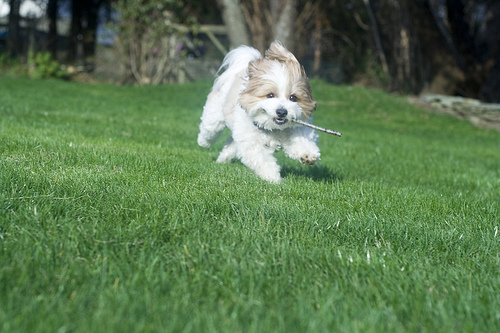

A man on a red bicycle rides past several pedestrians .
0.15
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


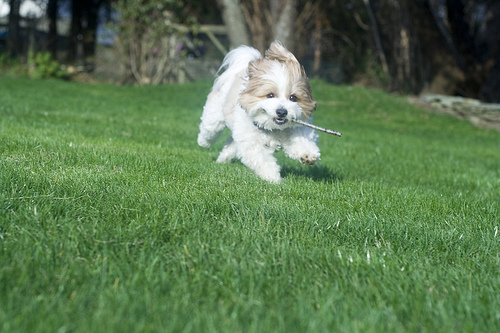

a small shaggy dog plays with a red ball on the grass .
0.075
None
This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


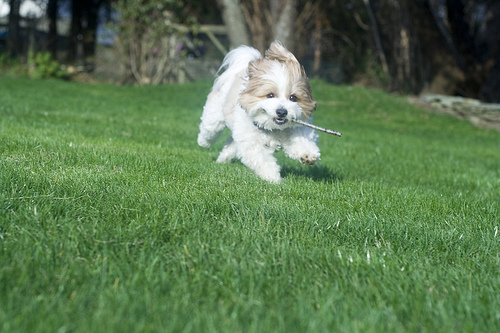

Two small white dogs chasing after a red ball .
0.078
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


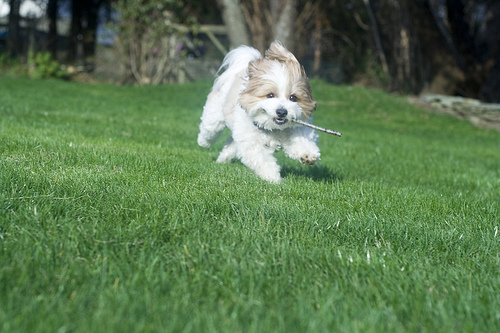

Two women on a movie set reviewing film
0.266
None
This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


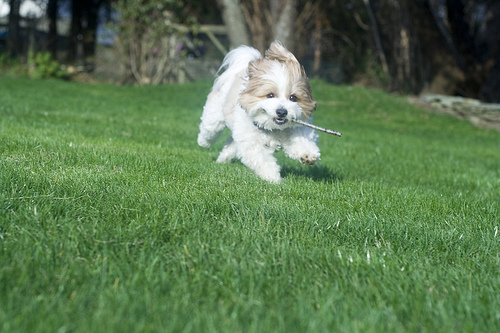

A man wearing glasses and black clothing is sitting while a man in a vest drinks in the background .
0.05
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


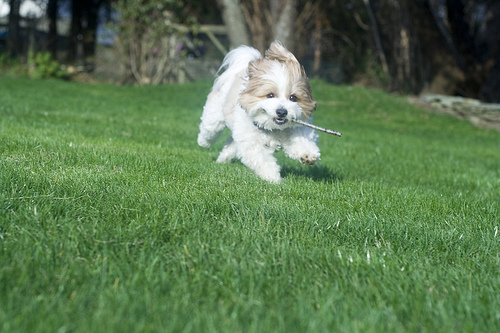

Two women are wearing lavender scarves an their heads .
0.044
None
This image is unavailable in your country in compliance with local laws.
None
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


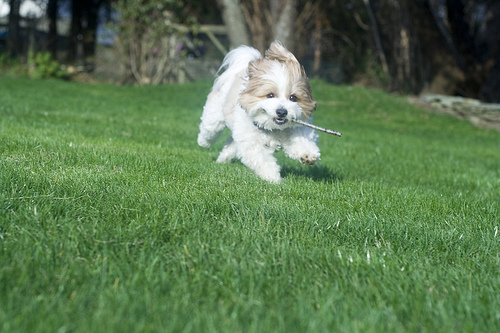

a lone man sitting on a ledge that overlooks the beach
0.081
None


In [58]:
for i in range(10):
    print(eval_query_nn(test_queries.loc[randrange(len(test_queries['query_text'])), 'query_text']))

Проведем тестирование модели линейной регрессии

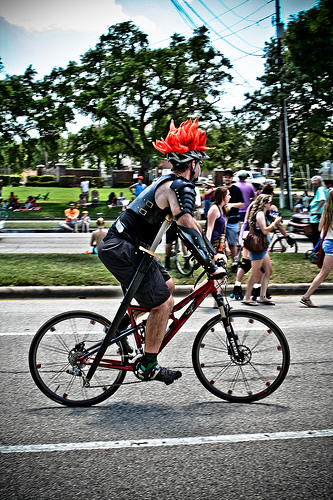

a large group of young people all dressed in white tops and green bottoms
-91246350.386
None
This image is unavailable in your country in compliance with local laws.
None


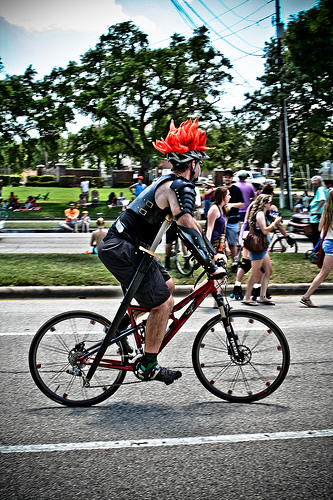

Two black dogs are fighting over a toy
249254899.908
None


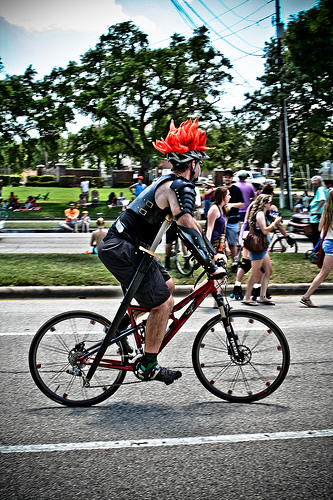

A group of people are ice skating in a big city .
14307725.526
None


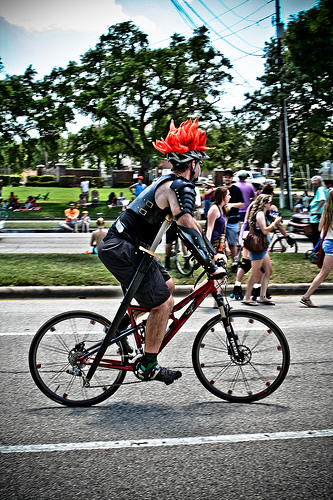

Two men are standing under what looks to be a giant robot .
23771195.159
None


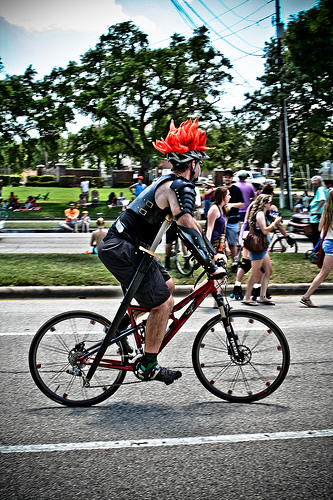

A group of six men stand in a circle playing instruments in a wooded parking lot .
-493764315.19
None
This image is unavailable in your country in compliance with local laws.
None


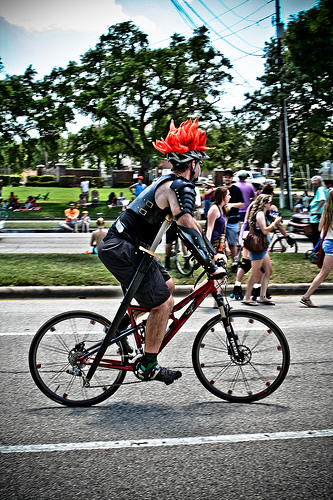

a large man dozes off on the bus .
547664618.036
None


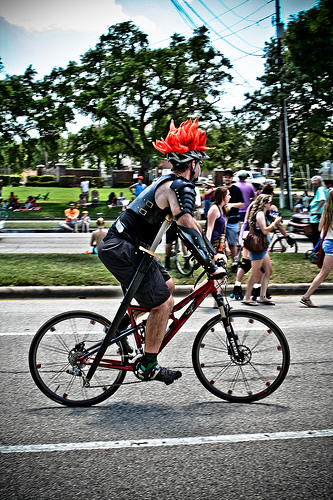

A red high speed racing boat skips across the water .
0.809
None


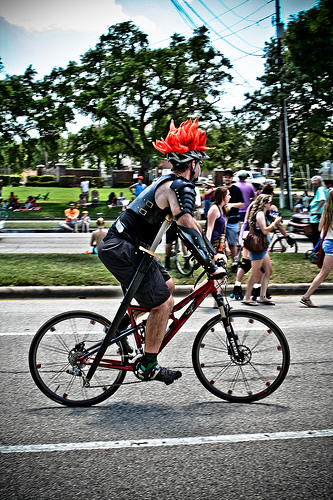

a boxer punches a boxer in the face .
-1364423920.849
None


In [59]:
for i in range(10):
    print(eval_query_model_lr(test_queries.loc[randrange(len(test_queries['query_text'])), 'query_text']))

Обе модели плохо предсказывают картинку по тексту. Модели выдают одну картинку на все запросы.

**Вывод:**

Мы провели мероприятия по обучению моделей с целью определения соответствия текстового запроса и изображения. <br>
 <br>
В рамках первого шага: <br>
Оформили цель и описание проекта. <br>
 <br>
В рамках второго шага: <br>
Загрузили и провели анализ загружаемых данных. <br>
 <br>
В рамках третьего шага: <br>
Удалили из обучающей выборки все запросы, в которых присутствует упоминение детей и разделили данные на обучающую и валидационную выборку в пропорции 7:3. <br>
 <br>
В рамках четвертого шага: <br>
Сделали две функции: <br>
1) Первая принимает имя файла изображения и путь до него, а на выходе выдает векторное представление данного изображения. <br>
2) Вторая принимает датафрейм с именами файлов изображений в столбце file_name и имя папки с изображениями. После отдает нам тот же датафрейм, но с добаленным столбцом img_vector, в котором хранится информация о векторе изображения из первой функции <br>
<br>
Также объединили датафрейм с обучающей и валидационной таблицей оценок<br>
<br>
В рамках пятого шага:<br>
Получили массив векторных представлений текстов<br>
<br>
В рамках шестого шага:<br>
Создали функцию, принимающую датафрейм и преобразует его в массив объединенных векторов изображений и текстов<br>
<br>
В рамках седьмого шага:<br>
Обучили две модели: <br>
LinearRegression с показателем MSE - 0.047 <br>
Полносвязную нейроную сеть с показателем MSE - 0.04 <br>
До тестирования допустим сразу две модели. <br>
 <br>
В рамках восьмого шага: <br>
Провели тестирование. Обе модели плохо предсказывают картинку по тексту. Модели выдают одну картинку на все запросы. <br>

## Выводы

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Исследовательский анализ данных выполнен
- [ ]  Проверены экспертные оценки и краудсорсинговые оценки
- [ ]  Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [ ]  Изображения векторизованы
- [ ]  Текстовые запросы векторизованы
- [ ]  Данные корректно разбиты на тренировочную и тестовую выборки
- [ ]  Предложена метрика качества работы модели
- [ ]  Предложена модель схожести изображений и текстового запроса
- [ ]  Модель обучена
- [ ]  По итогам обучения модели сделаны выводы
- [ ]  Проведено тестирование работы модели
- [ ]  По итогам тестирования визуально сравнили качество поиска